In [1]:
import numpy as np
from timeseries import TimeSeriesClassifier

In [2]:
%matplotlib notebook
from skmultiflow.trees import RegressionHoeffdingTree, MultiTargetRegressionHoeffdingTree, HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data import DataStream
import matplotlib as plt
import pandas as pd

plt.interactive(True)

dataset = "elec"

df = pd.read_csv("./data/"+dataset+".csv")
df.columns = [ str(i) for i in range(len(df.columns))]
df = pd.DataFrame({"t":df[df.columns[-1]].astype(np.float32).tolist()[:-1],"t+1":df[df.columns[-1]].tolist()[1:]})

stream = DataStream(df, n_targets=1, target_idx=-1)
stream.prepare_for_use()


<IPython.core.display.Javascript object>


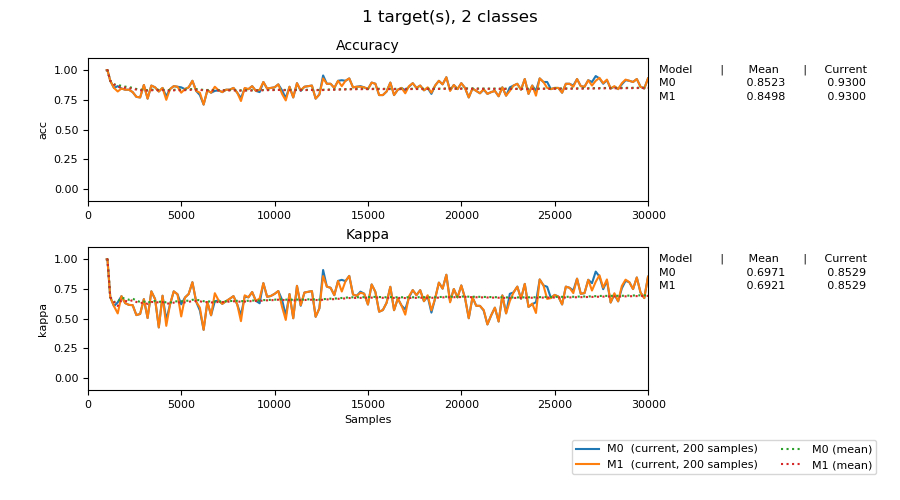

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [42.78s]
Processed samples: 30000
Mean performance:
M0 - Accuracy     : 0.8523
M0 - Kappa        : 0.6971
M1 - Accuracy     : 0.8498
M1 - Kappa        : 0.6921


[TimeSeriesClassifier(estimator=HoeffdingTree(binary_split=False,
                                              grace_period=200,
                                              leaf_prediction='nba',
                                              max_byte_size=33554432,
                                              memory_estimate_period=1000000,
                                              nb_threshold=0, no_preprune=False,
                                              nominal_attributes=None,
                                              remove_poor_atts=False,
                                              split_confidence=1e-07,
                                              split_criterion='info_gain',
                                              stop_mem_management=False,
                                              tie_threshold=0.05),
                      max_window_size=100),
 HoeffdingTree(binary_split=False, grace_period=200, leaf_prediction='nba',
               max_byte_si

In [3]:
h = HoeffdingTree()
model = TimeSeriesClassifier( HoeffdingTree(), max_window_size=100)

# 3. Setup the evaluator
evaluator = EvaluatePrequential(pretrain_size=1000, max_samples=30000, show_plot=True, 
                                metrics=['accuracy',"kappa"], output_file='result_'+dataset+'.csv', 
                                batch_size=10)
# 4. Run
evaluator.evaluate(stream=stream, model=[model,h])

In [4]:
h = HoeffdingTree()
model = TimeSeriesClassifier( HoeffdingTree(), max_window_size=100)

stream.restart()
y = stream.next_sample(batch_size=150)
model.partial_fit(y[0], y[1])

TimeSeriesClassifier(estimator=HoeffdingTree(binary_split=False,
                                             grace_period=200,
                                             leaf_prediction='nba',
                                             max_byte_size=33554432,
                                             memory_estimate_period=1000000,
                                             nb_threshold=0, no_preprune=False,
                                             nominal_attributes=None,
                                             remove_poor_atts=False,
                                             split_confidence=1e-07,
                                             split_criterion='info_gain',
                                             stop_mem_management=False,
                                             tie_threshold=0.05),
                     max_window_size=100)

In [5]:
predictions = []
targets = []
for i in range(100):
    y = stream.next_sample(batch_size=10)
    model.partial_fit(y[0], y[1])
    
for i in range(10100):
    y = stream.next_sample(batch_size=1)
    
    predictions.append(model.forcast(y[0],n_steps=100))
    targets.append(y[1])
    
    model.partial_fit(y[0], y[1])

In [11]:
offset = 100
score = np.abs(np.array(targets)[offset+0:, 0] == np.array(predictions)[offset:,0]).mean()
scores = [score]
for i in range(1,100):
    score = np.abs(np.array(targets)[offset+i:, 0] == np.array(predictions)[offset:-i,i]).mean()
    scores.append(score)

<IPython.core.display.Javascript object>


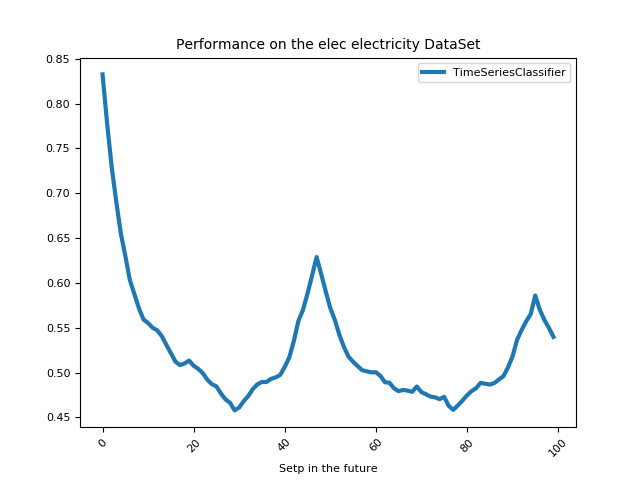

In [13]:
import pandas as pd
from matplotlib.pyplot import *

df = pd.DataFrame({"id": range(100), "acc":scores})
ax = df.plot(x="id", y=["acc"], rot=45, linewidth=3)
ax.set_xlabel("Setp in the future")
ax.set_title("Performance on the %s electricity DataSet" % dataset)
ax.legend([r"TimeSeriesClassifier"], loc='best')
show()